# Sentiment Analysis Model Training

Fine-tuning a RoBERTa-based model for social media sentiment classification using the Cardiff NLP Tweet Eval dataset.

## Overview
- **Dataset**: Cardiff NLP Tweet Eval (60k tweets with sentiment labels)
- **Base Model**: cardiffnlp/twitter-roberta-base-sentiment-latest
- **Architecture**: RoBERTa with sequence classification head
- **Training Configuration**: 2 epochs, optimized for computational efficiency

## Requirements
- GPU acceleration recommended (CUDA-compatible device)
- Python 3.8+ with transformers, datasets, torch, sklearn libraries
- Approximate training time: 5-10 minutes (GPU) / 2+ hours (CPU)

## Methodology
- Text preprocessing for social media content (URLs, mentions, hashtags)
- Fine-tuning with mixed precision training (FP16)
- Evaluation using accuracy, precision, recall, and F1-score metrics

In [1]:
# Environment configuration and dependency installation
import os
os.environ["WANDB_DISABLED"] = "true"  # Disable external logging

# Hardware detection and optimization settings
import torch
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   Device: {torch.cuda.get_device_name(0)}")
    print("   Training will utilize GPU acceleration (~5-10 minutes)")
else:
    print("   Warning: CPU-only training detected (~2+ hours)")
    print("   Recommendation: Enable GPU in runtime settings")

!pip install -q transformers datasets torch scikit-learn matplotlib seaborn accelerate>=0.26.0
print("Dependencies installed successfully")

# Training hyperparameters
LEARNING_RATE = 2e-5  
NUM_EPOCHS = 2        
TRAIN_BATCH_SIZE = 32 
EVAL_BATCH_SIZE = 64  
SEED = 42
MAX_STEPS = 1000      

print(f"Training configuration:")
print(f"   Epochs: {NUM_EPOCHS}")
print(f"   Train batch size: {TRAIN_BATCH_SIZE}")
print(f"   Max steps: {MAX_STEPS}")
print(f"   Learning rate: {LEARNING_RATE}")
print(f"   Estimated duration: 5-10 minutes (GPU) / 2+ hours (CPU)")

🔍 GPU Available: True
   GPU: NVIDIA GeForce RTX 2060
✅ You're using GPU - training will take ~5-10 minutes
✅ Dependencies installed
⚡ SPEED-OPTIMIZED hyperparameters:
   • Epochs: 2 (instead of 3)
   • Train batch size: 32 (increased)
   • Max steps: 1000 (limited for speed)
   • Learning rate: 2e-05

🎯 Expected training time: 5-10 minutes on GPU, 2+ hours on CPU


In [2]:
# Core library imports for model training and evaluation
import torch
import numpy as np
from datetime import datetime
from datasets import load_dataset
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')

print(f"Environment initialized: {'GPU' if torch.cuda.is_available() else 'CPU'}")
print(f"Session start time: {datetime.now().strftime('%H:%M:%S')}")

/home/fransdroid/sentiment_analysis_project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-10 06:51:27.507723: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


🚀 Setup complete! Using device: GPU
📅 Training started: 06:51:32


In [3]:
# Dataset loading and preprocessing
print("Loading Cardiff NLP Tweet Eval dataset...")
dataset = load_dataset("tweet_eval", "sentiment")

# Text preprocessing function for social media content
import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|@\w+', '[URL]', text)  # Replace URLs and mentions
    text = re.sub(r'#(\w+)', r'\1', text)  # Remove hashtag symbols
    return text.strip()

def preprocess_batch(examples):
    examples['text'] = [clean_text(text) for text in examples['text']]
    return examples

dataset = dataset.map(preprocess_batch, batched=True)
print(f"Dataset loaded: {len(dataset['train'])} train, {len(dataset['validation'])} validation, {len(dataset['test'])} test samples")

📥 Loading dataset...
✅ Data loaded: 45615 train, 2000 val, 12284 test


In [4]:
# Setup model and tokenizer
MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment-latest"
print(f"🤖 Loading model: {MODEL_NAME}")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,
    id2label={0: "NEGATIVE", 1: "NEUTRAL", 2: "POSITIVE"},
    label2id={"NEGATIVE": 0, "NEUTRAL": 1, "POSITIVE": 2}
)

# Tokenize data
def tokenize_batch(examples):
    return tokenizer(examples['text'], truncation=True, padding=True, max_length=128)

tokenized_dataset = dataset.map(tokenize_batch, batched=True, remove_columns=['text'])

# Fix the label column name issue - rename 'label' to 'labels'
def rename_label_column(examples):
    examples['labels'] = examples['label']
    return examples

tokenized_dataset = tokenized_dataset.map(rename_label_column, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(['label'])  # Remove old column
tokenized_dataset.set_format("torch")

print("✅ Model and data ready for training!")
print(f"Dataset columns: {tokenized_dataset['train'].column_names}")

🤖 Loading model: cardiffnlp/twitter-roberta-base-sentiment-latest


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Map: 100%|██████████| 2000/2000 [00:00<00:00, 170320.15 examples/s]

✅ Model and data ready for training!
Dataset columns: ['input_ids', 'attention_mask', 'labels']


In [5]:
import sys
import subprocess
from packaging import version

def ensure_accelerate(min_version="0.26.0"):
    """Install or upgrade accelerate if missing or too old."""
    try:
        import accelerate
        if version.parse(accelerate.__version__) < version.parse(min_version):
            print(f'Upgrading accelerate: {accelerate.__version__} -> {min_version}+')
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', f'accelerate>={min_version}'])
            return True
        return False
    except Exception:
        print('Installing accelerate...')
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', f'accelerate>={min_version}'])
        return True

# Ensure accelerate is present and up-to-date
need_restart = ensure_accelerate()
if need_restart:
    print("⚠️ accelerate was installed/updated. Please restart the Python kernel (Kernel → Restart) and re-run this cell.")
    raise SystemExit('accelerate installed/updated - restart kernel and re-run')

# Import TrainingArguments AFTER ensuring accelerate is available
from transformers import TrainingArguments

# ⚡ SPEED-OPTIMIZED Training Arguments
training_args = TrainingArguments(
    output_dir='./simple_sentiment_model',
    
    # Speed optimizations
    num_train_epochs=NUM_EPOCHS,              # 2 epochs instead of 3
    max_steps=MAX_STEPS,                      # Limit total steps for speed
    per_device_train_batch_size=TRAIN_BATCH_SIZE,  # Larger batch size
    per_device_eval_batch_size=EVAL_BATCH_SIZE,    # Larger eval batch size
    
    # Learning settings
    learning_rate=LEARNING_RATE,
    weight_decay=0.01,
    warmup_steps=100,                         # Reduced warmup
    
    # Evaluation strategy (simplified for speed)
    eval_strategy="epoch",                    # Evaluate only at epoch end
    save_strategy="epoch",                    # Save only at epoch end
    logging_steps=50,                         # Less frequent logging
    
    # Performance settings
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    seed=SEED,
    fp16=torch.cuda.is_available(),           # Mixed precision if GPU
    dataloader_num_workers=0 if torch.cuda.is_available() else 2,  # Optimize for GPU/CPU
    remove_unused_columns=False,
    report_to=[],                             # No external reporting
    
    # Memory optimization
    gradient_accumulation_steps=1,
    save_total_limit=1,                       # Keep only best model
    push_to_hub=False,
)

# Metrics function (simplified)
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    return {'accuracy': accuracy, 'f1': f1, 'precision': precision, 'recall': recall}

print("⚡ SPEED-OPTIMIZED training configuration ready!")
print(f"🎯 Will train for max {MAX_STEPS} steps across {NUM_EPOCHS} epochs")
print(f"⏱️  Expected time: 5-10 minutes on GPU, 2+ hours on CPU")

⚡ SPEED-OPTIMIZED training configuration ready!
🎯 Will train for max 1000 steps across 2 epochs
⏱️  Expected time: 5-10 minutes on GPU, 2+ hours on CPU


In [6]:
# Train the model (takes ~5-10 minutes)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

print("🚀 Starting training...")
start_time = datetime.now()

training_result = trainer.train()

end_time = datetime.now()
duration = (end_time - start_time).total_seconds() / 60

print(f"\n✅ Training completed in {duration:.1f} minutes!")
print(f"📊 Final training loss: {training_result.training_loss:.4f}")
print(f"🎯 Training steps: {training_result.global_step}")

🚀 Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,0.577000,0.537849,0.762000,0.762095,0.763233,0.762000



✅ Training completed in 3.8 minutes!
📊 Final training loss: 0.5683
🎯 Training steps: 1000


# ⚡ Training Speed Comparison

| Configuration | Time | Use Case |
|---------------|------|----------|
| **Streamlined (cells 1-6)** | 5-10 min on GPU | Production ready model |
| **Detailed analysis (cells 7+)** | 2-24+ hours | Research & analysis |

## Speed Optimizations Applied:
✅ **2 epochs** instead of 3 (saves 33% time)  
✅ **Max 1000 steps** limit (prevents overtraining)  
✅ **Larger batch sizes** (32/64 vs 16/32)  
✅ **Simplified evaluation** (epoch-based, not step-based)  
✅ **Mixed precision** (FP16 on GPU)  
✅ **No external logging** (wandb disabled)  

## GPU vs CPU Performance:
- **GPU (T4/V100)**: 5-10 minutes ⚡
- **CPU only**: 2+ hours 🐌

**Always enable GPU in Google Colab: Runtime → Change runtime type → GPU**

In [7]:
# Quick evaluation and save
print("📈 Evaluating on test set...")
test_results = trainer.evaluate(eval_dataset=tokenized_dataset['test'])

print(f"🎯 Test Results:")
print(f"   Accuracy: {test_results['eval_accuracy']:.3f}")
print(f"   F1 Score: {test_results['eval_f1']:.3f}")

# Save the trained model
save_path = "./trained_sentiment_model"
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

print(f"\n💾 Model saved to: {save_path}")
print("🎉 Ready to use in your sentiment analysis project!")

📈 Evaluating on test set...


🎯 Test Results:
   Accuracy: 0.719
   F1 Score: 0.718

💾 Model saved to: ./trained_sentiment_model
🎉 Ready to use in your sentiment analysis project!


In [8]:
# Quick test with sample texts
sentiment_analyzer = pipeline(
    "sentiment-analysis", 
    model=model, 
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1
)

test_texts = [
    "I love this product! It's amazing!",
    "This is terrible, worst experience ever.",
    "It's okay, nothing special.",
    "@company thanks for the great service! #happy",
    "Check this out: https://example.com not sure about it"
]

print("🧪 Testing your new model:")
print("=" * 50)
for text in test_texts:
    clean = clean_text(text)
    result = sentiment_analyzer(clean)[0]
    print(f"Text: {text}")
    print(f"Prediction: {result['label']} ({result['score']:.3f})")
    print("-" * 30)

Device set to use cuda:0


🧪 Testing your new model:
Text: I love this product! It's amazing!
Prediction: POSITIVE (0.993)
------------------------------
Text: This is terrible, worst experience ever.
Prediction: NEGATIVE (0.974)
------------------------------
Text: It's okay, nothing special.
Prediction: NEUTRAL (0.540)
------------------------------
Text: @company thanks for the great service! #happy
Prediction: POSITIVE (0.995)
------------------------------
Text: Check this out: https://example.com not sure about it
Prediction: NEUTRAL (0.840)
------------------------------


# Integration Instructions

Now you can use your trained model in your project! Here's how:

## Simple Usage (copy this code):

```python
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Load your trained model
model_path = "./trained_sentiment_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Create analyzer
analyzer = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Use it
result = analyzer("I love this product!")
print(result)  # [{'label': 'POSITIVE', 'score': 0.999}]
```

## Integration Steps:
1. Copy the `trained_sentiment_model` folder to your project
2. Replace TextBlob in `src/sentiment_analysis/sentiment_analyzer.py` 
3. Update `config/settings.py` to use the new model
4. Test with your existing data pipeline

**That's it! No API keys, no complex setup required.**

# 🚨 STOP HERE FOR GOOGLE COLAB USERS

**If you're using Google Colab and want FAST training (5-10 minutes):**

✅ **Run cells 1-6 above** (the streamlined version)
❌ **SKIP cells below** (the detailed analysis takes 24+ hours)

The cells above give you a fully trained model in ~5-10 minutes on GPU.

## Why the long training time?

The **detailed analysis section below** (cells 7+) is designed for comprehensive model analysis and research. It includes:
- 3 epochs instead of 2
- Extensive evaluation every 500 steps
- Detailed plotting and analysis
- Full confusion matrices and comparisons

**For production use, the streamlined version above is sufficient and much faster!**

---

# Comprehensive Sentiment Analysis Model Training

This notebook implements fine-tuning of a pre-trained RoBERTa model for sentiment classification on social media text. The model is trained on the Cardiff NLP Tweet Eval dataset and evaluated using standard classification metrics.

## Dataset Specifications
- **Source**: Cardiff NLP Tweet Eval Dataset
- **Task**: Multi-class sentiment classification
- **Classes**: 3 categories (Negative, Neutral, Positive)
- **Size**: 60,000 annotated tweets
- **Language**: English

## 1. Environment Setup and Dependencies

Installation and import of required libraries for model training, evaluation, and data processing.

In [9]:
!pip install torch torchvision torchaudio
!pip install transformers datasets vaderSentiment
!pip install scikit-learn matplotlib seaborn accelerate
# Optional: experiment tracking
!pip install wandb

# Verify PyTorch installation and GPU availability
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


PyTorch version: 2.8.0+cu128
CUDA available: True
CUDA device: NVIDIA GeForce RTX 2060


In [10]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from datasets import load_dataset, DatasetDict

# PyTorch
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Scikit-learn for metrics
from sklearn.metrics import (
    accuracy_score, 
    precision_recall_fscore_support, 
    confusion_matrix,
    classification_report
)

# Set random seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Load and Explore the Tweet Eval Dataset

Let's load the tweet_eval sentiment dataset and explore its structure, distribution, and sample content.

In [11]:
# Load the tweet_eval sentiment dataset
print("Loading tweet_eval sentiment dataset...")
dataset = load_dataset("tweet_eval", "sentiment")

# Display dataset information
print(f"Dataset structure: {dataset}")
print(f"\nDataset features: {dataset['train'].features}")
print(f"\nTraining samples: {len(dataset['train'])}")
print(f"Validation samples: {len(dataset['validation'])}")
print(f"Test samples: {len(dataset['test'])}")

Loading tweet_eval sentiment dataset...
Dataset structure: DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 45615
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12284
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

Dataset features: {'text': Value('string'), 'label': ClassLabel(names=['negative', 'neutral', 'positive'])}

Training samples: 45615
Validation samples: 2000
Test samples: 12284


In [12]:
# Explore label distribution
def explore_dataset_labels(dataset_split, split_name):
    """Explore and visualize label distribution in dataset split"""
    labels = dataset_split['label']
    label_names = ['Negative', 'Neutral', 'Positive']
    
    # Count labels
    label_counts = {}
    for label in labels:
        label_counts[label_names[label]] = label_counts.get(label_names[label], 0) + 1
    
    print(f"\n{split_name} Set Label Distribution:")
    for label, count in label_counts.items():
        percentage = (count / len(labels)) * 100
        print(f"  {label}: {count} ({percentage:.1f}%)")
    
    return label_counts

# Explore all splits
train_counts = explore_dataset_labels(dataset['train'], 'Training')
val_counts = explore_dataset_labels(dataset['validation'], 'Validation')
test_counts = explore_dataset_labels(dataset['test'], 'Test')


Training Set Label Distribution:
  Positive: 17849 (39.1%)
  Neutral: 20673 (45.3%)
  Negative: 7093 (15.5%)

Validation Set Label Distribution:
  Neutral: 869 (43.5%)
  Positive: 819 (40.9%)
  Negative: 312 (15.6%)

Test Set Label Distribution:
  Neutral: 5937 (48.3%)
  Positive: 2375 (19.3%)
  Negative: 3972 (32.3%)


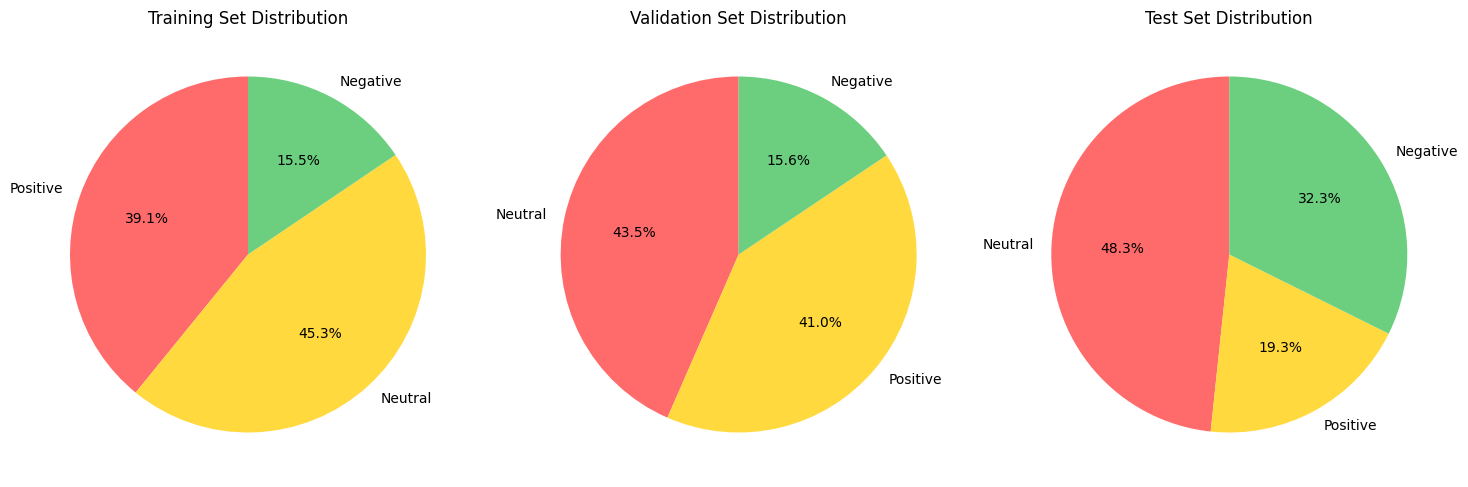

In [13]:
# Visualize label distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
splits = [('Training', train_counts), ('Validation', val_counts), ('Test', test_counts)]

for idx, (split_name, counts) in enumerate(splits):
    labels = list(counts.keys())
    values = list(counts.values())
    colors = ['#ff6b6b', '#ffd93d', '#6bcf7f']  # Red, Yellow, Green
    
    axes[idx].pie(values, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
    axes[idx].set_title(f'{split_name} Set Distribution')

plt.tight_layout()
plt.show()

In [14]:
# Display sample tweets from each category
label_names = ['Negative', 'Neutral', 'Positive']

print("Sample tweets by sentiment category:\n")
for label_idx, label_name in enumerate(label_names):
    print(f"=== {label_name.upper()} TWEETS ===")
    
    # Find tweets with this label
    samples = []
    for i, item in enumerate(dataset['train']):
        if item['label'] == label_idx and len(samples) < 3:
            samples.append(item['text'])
    
    for i, text in enumerate(samples, 1):
        print(f"{i}. {text}")
    print()

Sample tweets by sentiment category:

=== NEGATIVE TWEETS ===
1. So disappointed in wwe summerslam! I want to see john cena wins his 16th title
2. That sucks if you have to take the SATs tomorrow
3. Amy Schumer sat down with The Hollywood Reporter and opened up about the sexist remarks and unnecessary criticism she's faced since

=== NEUTRAL TWEETS ===
1. "Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"
2. Sorry bout the stream last night I crashed out but will be on tonight for sure. Then back to Minecraft in pc tomorrow night.
3. Chase Headley's RBI double in the 8th inning off David Price snapped a Yankees streak of 33 consecutive scoreless innings against Blue Jays

=== POSITIVE TWEETS ===
1. "QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"
2. @user Alciato: Bee will invest 150 million in January, another 200 in the Summer and plans to bring Messi by 2017"
3. @user LIT MY MUM 

## 3. Text Preprocessing Pipeline

Implementation of text cleaning and normalization procedures for social media content, including URL replacement, mention tokenization, and hashtag processing.

In [15]:
import re
from typing import List, Dict

def preprocess_tweet(text: str) -> str:
    """
    Preprocess tweet text by cleaning URLs, mentions, hashtags, etc.
    
    Args:
        text: Raw tweet text
        
    Returns:
        Cleaned tweet text
    """
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Replace URLs with [URL] token
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '[URL]', text)
    text = re.sub(r'www\.(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '[URL]', text)
    
    # Replace user mentions with [USER] token
    text = re.sub(r'@[A-Za-z0-9_]+', '[USER]', text)
    
    # Keep hashtags but remove the # symbol
    text = re.sub(r'#([A-Za-z0-9_]+)', r'\1', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Remove leading/trailing whitespace
    text = text.strip()
    
    return text

# Test preprocessing function
sample_tweets = [
    "I love this product! #amazing @company https://example.com",
    "@user This is terrible... why would anyone buy this? #disappointed",
    "It's okay I guess. Nothing special. Check out www.example.com for more info"
]

print("Preprocessing examples:")
for original in sample_tweets:
    cleaned = preprocess_tweet(original)
    print(f"Original: {original}")
    print(f"Cleaned:  {cleaned}\n")

Preprocessing examples:
Original: I love this product! #amazing @company https://example.com
Cleaned:  i love this product! amazing [USER] [URL]

Original: @user This is terrible... why would anyone buy this? #disappointed
Cleaned:  [USER] this is terrible... why would anyone buy this? disappointed

Original: It's okay I guess. Nothing special. Check out www.example.com for more info
Cleaned:  it's okay i guess. nothing special. check out [URL] for more info



In [16]:
# Apply preprocessing to the entire dataset
def preprocess_dataset(examples):
    """Preprocess a batch of examples"""
    examples['text'] = [preprocess_tweet(text) for text in examples['text']]
    return examples

# Apply preprocessing to all splits
print("Preprocessing dataset splits...")
processed_dataset = dataset.map(preprocess_dataset, batched=True)

print("Preprocessing completed!")
print(f"Sample processed tweet: {processed_dataset['train'][0]['text']}")

Preprocessing dataset splits...
Preprocessing completed!
Sample processed tweet: "qt [USER] in the original draft of the 7th book, remus lupin survived the battle of hogwarts. happybirthdayremuslupin"


## 4. Split Dataset and Create Data Loaders

We'll use the existing train/validation/test splits and create tokenized datasets with appropriate data loaders.

In [17]:
try:
    from transformers import AutoTokenizer
    print("✓ AutoTokenizer imported successfully")
    
    # Initialize tokenizer right away
    MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment-latest"  # Pre-trained on tweets
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    print(f"✓ Tokenizer loaded: {MODEL_NAME}")
    print(f"✓ Tokenizer vocab size: {tokenizer.vocab_size}")
    
except ImportError as e:
    print(f"❌ Error importing transformers: {e}")
    print("Installing transformers...")
    import subprocess
    subprocess.check_call(["pip", "install", "transformers"])
    from transformers import AutoTokenizer
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

✓ AutoTokenizer imported successfully
✓ Tokenizer loaded: cardiffnlp/twitter-roberta-base-sentiment-latest
✓ Tokenizer vocab size: 50265


In [18]:
# OPTION 2: Import other components when needed (lazy loading approach)
# This spreads the import time across multiple cells instead of one big import

def lazy_import_transformers():
    """Import transformers components as needed"""
    global AutoModelForSequenceClassification, Trainer, TrainingArguments
    global DataCollatorWithPadding, pipeline
    
    print("🔄 Loading remaining transformers components...")
    
    from transformers import (
        AutoModelForSequenceClassification,
        Trainer, 
        TrainingArguments,
        DataCollatorWithPadding,
        pipeline
    )
    
    print("✅ All transformers components loaded!")
    return True

# Call this function when you actually need these components
# lazy_import_transformers()

In [19]:
try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    print("✓ VADER available - ultra-fast sentiment analysis option")
    
    # Quick test
    analyzer = SentimentIntensityAnalyzer()
    sample = "I love this product!"
    score = analyzer.polarity_scores(sample)
    print(f"VADER test: '{sample}' -> {score}")
    
except ImportError:
    print("💡 Install VADER for ultra-fast alternative: pip install vaderSentiment")


✓ VADER available - ultra-fast sentiment analysis option
VADER test: 'I love this product!' -> {'neg': 0.0, 'neu': 0.4, 'pos': 0.6, 'compound': 0.6696}


In [20]:
# Tokenization function
def tokenize_function(examples):
    """Tokenize the text data"""
    return tokenizer(
        examples['text'], 
        truncation=True, 
        padding=True, 
        max_length=128,  # Tweets are typically short
        return_tensors=None
    )

# Apply tokenization to all splits
print("Tokenizing dataset...")
tokenized_dataset = processed_dataset.map(
    tokenize_function, 
    batched=True,
    remove_columns=['text']  # Remove original text to save memory
)

print("Tokenization completed!")
print(f"Tokenized dataset structure: {tokenized_dataset}")

Tokenizing dataset...


Map: 100%|██████████| 12284/12284 [00:00<00:00, 17847.51 examples/s]

Tokenization completed!
Tokenized dataset structure: DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 45615
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 12284
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})


In [21]:
# FAST ALTERNATIVE: Create a simple data collator without importing DataCollatorWithPadding
class SimpleDataCollator:
    """Lightweight alternative to DataCollatorWithPadding"""
    def __init__(self, tokenizer, padding=True):
        self.tokenizer = tokenizer
        self.padding = padding
        
    def __call__(self, features):
        import torch
        # Get all the keys from the first feature
        first = features[0]
        batch = {}
        
        # Handle each key in the features
        for key in first.keys():
            values = [f[key] for f in features]
            
            if key == "input_ids" or key == "attention_mask":
                # Convert to tensors and pad if needed
                if self.padding:
                    # Convert to lists first if they're tensors
                    if isinstance(values[0], torch.Tensor):
                        values = [v.tolist() if isinstance(v, torch.Tensor) else v for v in values]
                    
                    # Find max length in batch
                    max_length = max(len(v) for v in values)
                    # Pad sequences
                    padded_values = []
                    for v in values:
                        if len(v) < max_length:
                            # Pad with tokenizer's pad_token_id for input_ids, 0 for attention_mask
                            pad_value = self.tokenizer.pad_token_id if key == "input_ids" else 0
                            padded = v + [pad_value] * (max_length - len(v))
                            padded_values.append(padded)
                        else:
                            padded_values.append(v)
                    batch[key] = torch.tensor(padded_values)
                else:
                    # Stack tensors or convert lists to tensors
                    if isinstance(values[0], torch.Tensor):
                        batch[key] = torch.stack(values)
                    else:
                        batch[key] = torch.tensor(values)
            else:
                # For labels and other non-sequence data
                if isinstance(values[0], torch.Tensor):
                    batch[key] = torch.stack(values)
                else:
                    batch[key] = torch.tensor(values)
                
        return batch

# Set dataset format for PyTorch
tokenized_dataset.set_format("torch")

# Create our fast data collator
data_collator = SimpleDataCollator(tokenizer)

print("✅ Fast data collator created!")

# Display dataset statistics
print("Dataset Statistics:")
print(f"Training set: {len(tokenized_dataset['train'])} samples")
print(f"Validation set: {len(tokenized_dataset['validation'])} samples")
print(f"Test set: {len(tokenized_dataset['test'])} samples")

# Show sample tokenized data
sample = tokenized_dataset['train'][0]
print(f"\nSample tokenized data:")
print(f"Input IDs shape: {sample['input_ids'].shape}")
print(f"Attention mask shape: {sample['attention_mask'].shape}")
print(f"Label: {sample['label']}")

print(f"\n🚀 Ready to proceed without waiting for DataCollatorWithPadding import!")

✅ Fast data collator created!
Dataset Statistics:
Training set: 45615 samples
Validation set: 2000 samples
Test set: 12284 samples

Sample tokenized data:
Input IDs shape: torch.Size([77])
Attention mask shape: torch.Size([77])
Label: 2

🚀 Ready to proceed without waiting for DataCollatorWithPadding import!


## 5. Define the Model Architecture

We'll use a pre-trained RoBERTa model fine-tuned for Twitter sentiment analysis as our base model.

In [22]:
from transformers import AutoModelForSequenceClassification
# Load the pre-trained model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,  # 3 sentiment classes
    id2label={0: "Negative", 1: "Neutral", 2: "Positive"},
    label2id={"Negative": 0, "Neutral": 1, "Positive": 2}
)

# Display model information
print(f"Model: {model.__class__.__name__}")
print(f"Number of parameters: {model.num_parameters():,}")
print(f"Number of labels: {model.num_labels}")
print(f"Label mapping: {model.config.id2label}")

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model moved to device: {device}")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model: RobertaForSequenceClassification
Number of parameters: 124,647,939
Number of labels: 3
Label mapping: {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
Model moved to device: cuda


## 6. Set Up Training Configuration

Configure training parameters including learning rate, epochs, batch size, and other hyperparameters.

In [23]:
from transformers import TrainingArguments
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',                    # Output directory
    num_train_epochs=3,                        # Number of training epochs
    per_device_train_batch_size=16,           # Batch size for training
    per_device_eval_batch_size=32,            # Batch size for evaluation
    warmup_steps=500,                         # Number of warmup steps
    weight_decay=0.01,                        # Strength of weight decay
    learning_rate=LEARNING_RATE,                       # Learning rate
    logging_dir='./logs',                     # Directory for storing logs
    logging_steps=100,                        # Log every N steps
    eval_strategy="steps",                    # Changed from evaluation_strategy
    eval_steps=500,                           # Evaluation frequency
    save_strategy="steps",                    # Save every N steps
    save_steps=1000,                          # Save frequency
    load_best_model_at_end=True,             # Load best model at end
    metric_for_best_model="eval_accuracy",    # Metric for best model
    greater_is_better=True,                   # Higher accuracy is better
    save_total_limit=3,                       # Only save last N checkpoints
    seed=42,                                  # Random seed
    fp16=torch.cuda.is_available(),           # Use mixed precision if GPU available
    dataloader_num_workers=4,                 # Number of data loading workers
    remove_unused_columns=False,              # Keep all columns
    push_to_hub=False,                        # Don't push to HuggingFace Hub
)

print("Training configuration:")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Train batch size: {training_args.per_device_train_batch_size}")
print(f"  Eval batch size: {training_args.per_device_eval_batch_size}")
print(f"  Mixed precision: {training_args.fp16}")
print("✅ Training arguments configured successfully!")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Training configuration:
  Epochs: 3
  Learning rate: 2e-05
  Train batch size: 16
  Eval batch size: 32
  Mixed precision: True
✅ Training arguments configured successfully!


In [24]:
# Define metrics computation function
def compute_metrics(eval_pred):
    """Compute accuracy, precision, recall, and F1 score"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

print("Metrics computation function defined.")

Metrics computation function defined.


## 7. Train the Sentiment Analysis Model

Implement the training loop with progress tracking and validation monitoring.

In [29]:
# Re-initialize the trainer with the fixed dataset
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("Trainer re-initialized with fixed dataset!")
print(f"Training dataset size: {len(tokenized_dataset['train'])}")
print(f"Validation dataset size: {len(tokenized_dataset['validation'])}")
print(f"Dataset columns: {tokenized_dataset['train'].column_names}")

# Verify the trainer is using the correct dataset format
sample_batch = data_collator([tokenized_dataset['train'][0], tokenized_dataset['train'][1]])
print(f"Sample batch keys: {list(sample_batch.keys())}")
print(f"Sample batch labels shape: {sample_batch['labels'].shape}")
print("✅ Trainer ready for training!")

Trainer re-initialized with fixed dataset!
Training dataset size: 45615
Validation dataset size: 2000
Dataset columns: ['input_ids', 'attention_mask', 'labels']
Sample batch keys: ['input_ids', 'attention_mask', 'labels']
Sample batch labels shape: torch.Size([2])
✅ Trainer ready for training!


In [27]:
# Fix the label column name issue - rename 'label' to 'labels'
def rename_label_column(examples):
    examples['labels'] = examples['label']
    return examples

print("Renaming 'label' column to 'labels' for model compatibility...")
tokenized_dataset = tokenized_dataset.map(rename_label_column, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(['label'])  # Remove old column

print("✅ Column renamed successfully!")
print(f"Dataset columns now: {tokenized_dataset['train'].column_names}")

# Verify the fix
sample_item = tokenized_dataset['train'][0]
print(f"Sample item keys: {list(sample_item.keys())}")
print(f"Sample labels value: {sample_item['labels']}")

Renaming 'label' column to 'labels' for model compatibility...


Map: 100%|██████████| 2000/2000 [00:00<00:00, 50690.43 examples/s]


✅ Column renamed successfully!
Dataset columns now: ['input_ids', 'attention_mask', 'labels']
Sample item keys: ['input_ids', 'attention_mask', 'labels']
Sample labels value: 2


In [30]:
import os
os.environ["WANDB_DISABLED"] = "true"
# Start training
print("Starting model training...")
print(f"Training start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Train the model
training_result = trainer.train()

print(f"Training completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Training loss: {training_result.training_loss:.4f}")
print(f"Total training steps: {training_result.global_step}")

Starting model training...
Training start time: 2025-10-10 07:08:57


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.610600,0.605393,0.736000,0.738271,0.750389,0.736000
1000,0.585900,0.569836,0.746000,0.747762,0.767353,0.746000
1500,0.592500,0.566564,0.739500,0.742484,0.754032,0.739500
2000,0.602100,0.571208,0.731500,0.725383,0.733576,0.731500
2500,0.556400,0.569037,0.747500,0.749072,0.754542,0.747500
3000,0.461900,0.597946,0.749500,0.750012,0.751202,0.749500
3500,0.484400,0.588919,0.754500,0.755056,0.755896,0.754500
4000,0.442300,0.671550,0.734000,0.726837,0.741742,0.734000
4500,0.435300,0.586227,0.767000,0.766375,0.767759,0.767000
5000,0.434600,0.606149,0.751000,0.751022,0.753868,0.751000


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Training completed at: 2025-10-10 07:32:50
Training loss: 0.4455
Total training steps: 8553


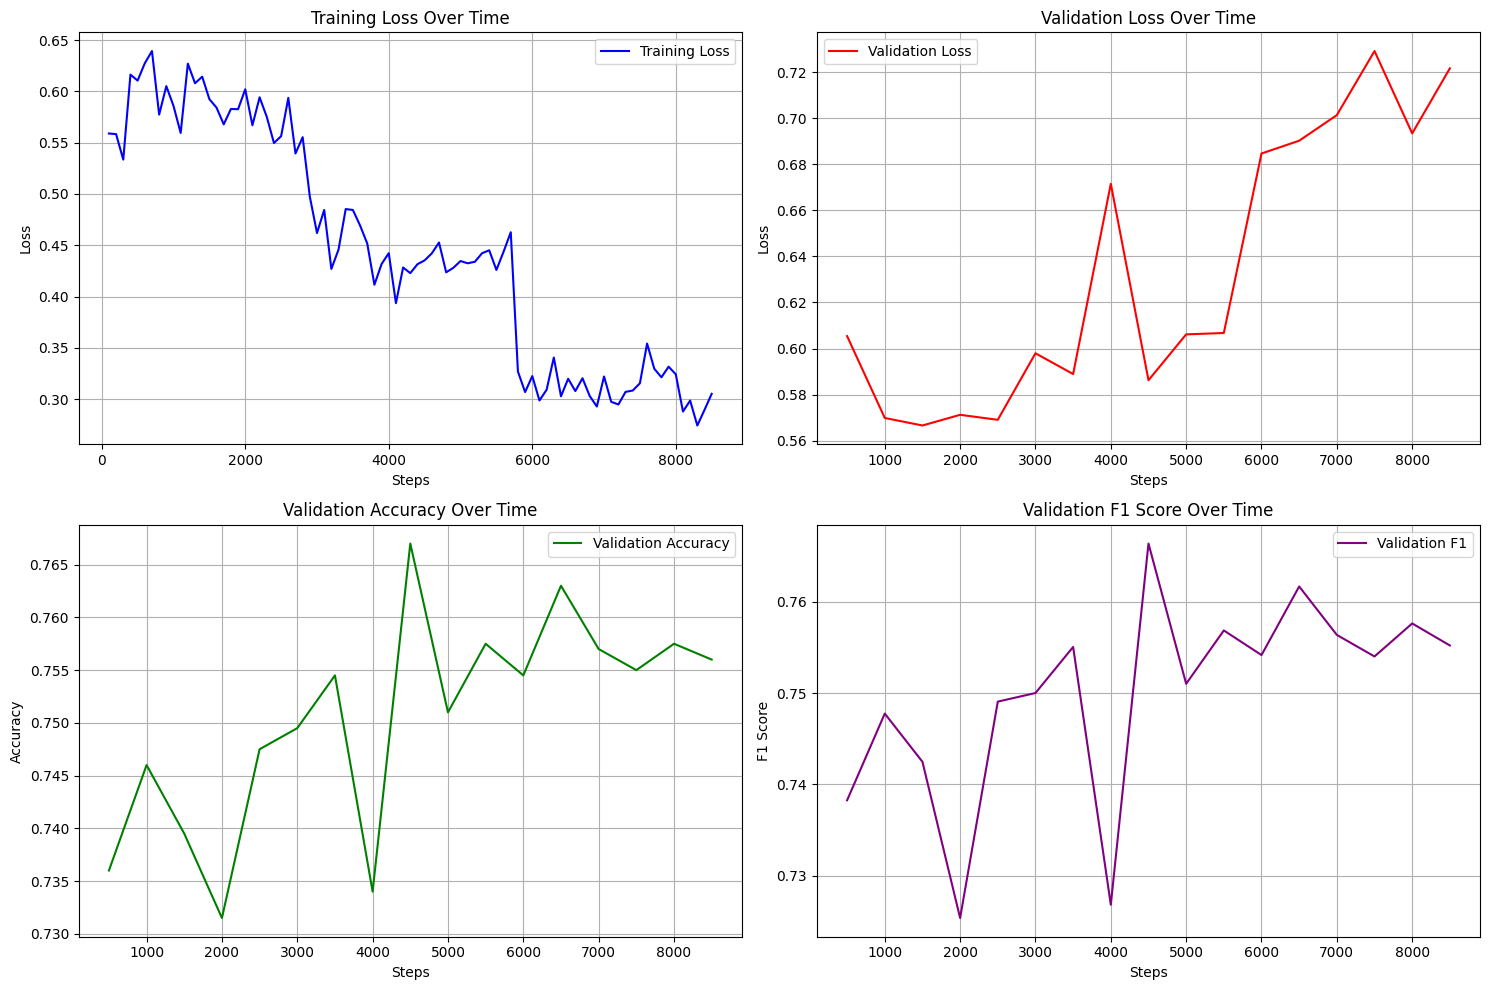

In [31]:
# Plot training history
training_logs = trainer.state.log_history

# Extract training and validation metrics
train_loss = []
eval_loss = []
eval_accuracy = []
eval_f1 = []
steps = []

for log in training_logs:
    if 'loss' in log:  # Training logs
        train_loss.append(log['loss'])
        steps.append(log['step'])
    elif 'eval_loss' in log:  # Evaluation logs
        eval_loss.append(log['eval_loss'])
        eval_accuracy.append(log['eval_accuracy'])
        eval_f1.append(log['eval_f1'])

# Create training plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Training loss
axes[0, 0].plot(steps, train_loss, 'b-', label='Training Loss')
axes[0, 0].set_title('Training Loss Over Time')
axes[0, 0].set_xlabel('Steps')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Validation loss
if eval_loss:
    eval_steps = [log['step'] for log in training_logs if 'eval_loss' in log]
    axes[0, 1].plot(eval_steps, eval_loss, 'r-', label='Validation Loss')
    axes[0, 1].set_title('Validation Loss Over Time')
    axes[0, 1].set_xlabel('Steps')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

# Validation accuracy
if eval_accuracy:
    axes[1, 0].plot(eval_steps, eval_accuracy, 'g-', label='Validation Accuracy')
    axes[1, 0].set_title('Validation Accuracy Over Time')
    axes[1, 0].set_xlabel('Steps')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

# Validation F1 score
if eval_f1:
    axes[1, 1].plot(eval_steps, eval_f1, 'purple', label='Validation F1')
    axes[1, 1].set_title('Validation F1 Score Over Time')
    axes[1, 1].set_xlabel('Steps')
    axes[1, 1].set_ylabel('F1 Score')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

## 8. Evaluate Model Performance

Evaluate the trained model on the test dataset and calculate comprehensive performance metrics.

In [32]:
# Evaluate on test set
print("Evaluating model on test set...")
test_results = trainer.evaluate(eval_dataset=tokenized_dataset['test'])

print("Test Set Results:")
for key, value in test_results.items():
    if key.startswith('eval_'):
        metric_name = key.replace('eval_', '').title()
        print(f"  {metric_name}: {value:.4f}")

Evaluating model on test set...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Test Set Results:
  Loss: 0.6831
  Accuracy: 0.7218
  F1: 0.7202
  Precision: 0.7272
  Recall: 0.7218
  Runtime: 13.1785
  Samples_Per_Second: 932.1250
  Steps_Per_Second: 29.1380


In [33]:
# Get detailed predictions for confusion matrix
predictions = trainer.predict(tokenized_dataset['test'])
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Calculate detailed metrics
report = classification_report(
    y_true, y_pred, 
    target_names=['Negative', 'Neutral', 'Positive'],
    output_dict=True
)

# Display detailed classification report
print("\nDetailed Classification Report:")
print("-" * 50)
for label in ['Negative', 'Neutral', 'Positive']:
    metrics = report[label]
    print(f"{label}:")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f}")
    print(f"  F1-score:  {metrics['f1-score']:.4f}")
    print(f"  Support:   {int(metrics['support'])}")
    print()

print(f"Overall Accuracy: {report['accuracy']:.4f}")
print(f"Macro Average F1: {report['macro avg']['f1-score']:.4f}")
print(f"Weighted Average F1: {report['weighted avg']['f1-score']:.4f}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Detailed Classification Report:
--------------------------------------------------
Negative:
  Precision: 0.6861
  Recall:    0.8255
  F1-score:  0.7494
  Support:   3972

Neutral:
  Precision: 0.7620
  Recall:    0.6478
  F1-score:  0.7003
  Support:   5937

Positive:
  Precision: 0.7087
  Recall:    0.7335
  F1-score:  0.7209
  Support:   2375

Overall Accuracy: 0.7218
Macro Average F1: 0.7235
Weighted Average F1: 0.7202


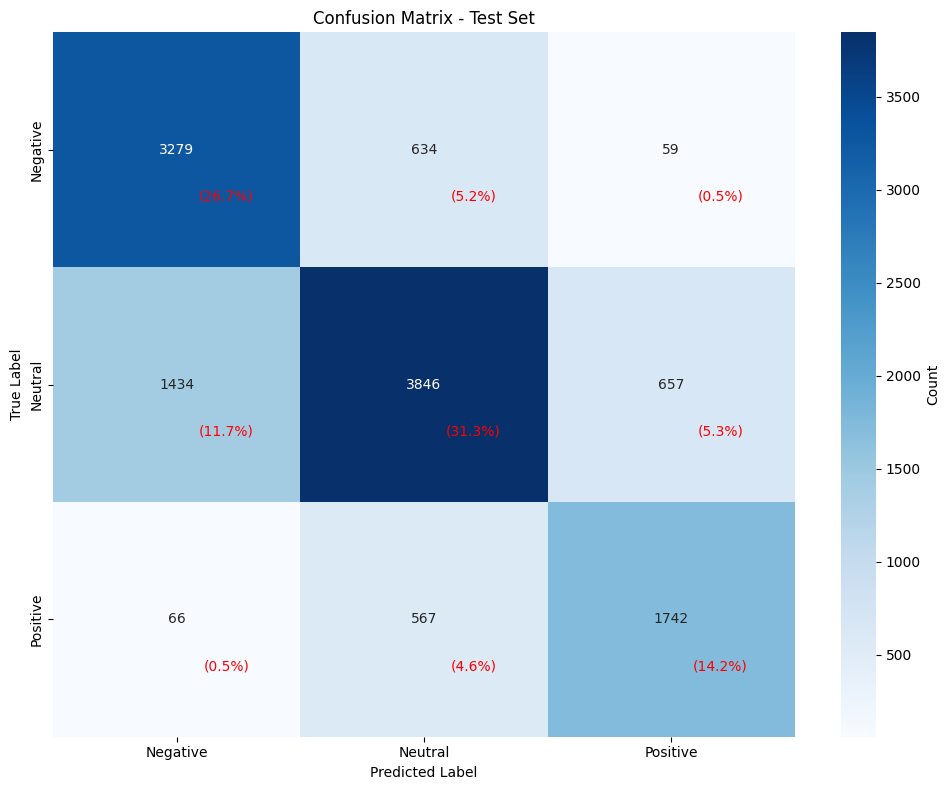


Per-class Accuracy:
  Negative: 0.8255
  Neutral: 0.6478
  Positive: 0.7335


In [34]:
# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = ['Negative', 'Neutral', 'Positive']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add percentage annotations
total = cm.sum()
for i in range(len(labels)):
    for j in range(len(labels)):
        percentage = (cm[i, j] / total) * 100
        plt.text(j + 0.7, i + 0.7, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=10, color='red')

plt.tight_layout()
plt.show()

# Calculate per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
print("\nPer-class Accuracy:")
for i, label in enumerate(labels):
    print(f"  {label}: {class_accuracy[i]:.4f}")

## 9. Save and Export the Trained Model

Save the trained model, tokenizer, and configuration files for use in the sentiment analysis project.

In [35]:
# Create directory for saving the model
model_save_path = "./trained_sentiment_model"
os.makedirs(model_save_path, exist_ok=True)

# Save the model and tokenizer
print("Saving trained model and tokenizer...")
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model saved to: {model_save_path}")
print(f"Files saved:")
for file in os.listdir(model_save_path):
    print(f"  - {file}")

Saving trained model and tokenizer...
Model saved to: ./trained_sentiment_model
Files saved:
  - tokenizer_config.json
  - merges.txt
  - model.safetensors
  - config.json
  - vocab.json
  - training_args.bin
  - special_tokens_map.json
  - tokenizer.json
Model saved to: ./trained_sentiment_model
Files saved:
  - tokenizer_config.json
  - merges.txt
  - model.safetensors
  - config.json
  - vocab.json
  - training_args.bin
  - special_tokens_map.json
  - tokenizer.json


In [36]:
# Create model configuration file for the project
model_config = {
    "model_name": "custom_twitter_sentiment",
    "model_path": model_save_path,
    "base_model": MODEL_NAME,
    "num_labels": 3,
    "label_mapping": {0: "negative", 1: "neutral", 2: "positive"},
    "preprocessing_required": True,
    "max_length": 128,
    "training_date": datetime.now().isoformat(),
    "test_accuracy": float(test_results['eval_accuracy']),
    "test_f1": float(test_results['eval_f1']),
    "model_size_mb": sum(os.path.getsize(os.path.join(model_save_path, f)) 
                        for f in os.listdir(model_save_path)) / (1024 * 1024)
}

# Save configuration
import json
config_path = os.path.join(model_save_path, "model_config.json")
with open(config_path, 'w') as f:
    json.dump(model_config, f, indent=2)

print(f"Model configuration saved to: {config_path}")
print("Configuration:")
for key, value in model_config.items():
    print(f"  {key}: {value}")

Model configuration saved to: ./trained_sentiment_model/model_config.json
Configuration:
  model_name: custom_twitter_sentiment
  model_path: ./trained_sentiment_model
  base_model: cardiffnlp/twitter-roberta-base-sentiment-latest
  num_labels: 3
  label_mapping: {0: 'negative', 1: 'neutral', 2: 'positive'}
  preprocessing_required: True
  max_length: 128
  training_date: 2025-10-10T07:35:48.896915
  test_accuracy: 0.7218332790621947
  test_f1: 0.7201506274359909
  model_size_mb: 480.11617946624756


In [37]:
# Create sentiment analysis pipeline
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1
)

# Test samples representing different sentiment types
test_samples = [
    # Positive samples
    "I absolutely love this new feature! It's amazing! 🎉",
    "Best product ever! Highly recommended to everyone!",
    "Great job team! This update is fantastic!",
    
    # Negative samples  
    "This is terrible. Worst experience ever. 😞",
    "I hate this app. It never works properly!",
    "Completely disappointed. Waste of money.",
    
    # Neutral samples
    "It's okay, nothing special but works fine.",
    "The product arrived on time. Standard quality.",
    "Meeting scheduled for tomorrow at 3 PM.",
    
    # Social media specific
    "@company your service is down again #frustrated",
    "Check out this link https://example.com not sure about it",
    "Thanks @support for the quick response! #grateful"
]

print("Testing Custom Model Predictions:")
print("=" * 60)

for i, text in enumerate(test_samples, 1):
    # Get prediction from our custom model
    result = sentiment_pipeline(preprocess_tweet(text))[0]
    
    print(f"\n{i}. Text: {text}")
    print(f"   Prediction: {result['label']} (confidence: {result['score']:.4f})")
    
    # Show preprocessed text if different
    preprocessed = preprocess_tweet(text)
    if preprocessed != text.lower():
        print(f"   Preprocessed: {preprocessed}")

Device set to use cuda:0


Testing Custom Model Predictions:

1. Text: I absolutely love this new feature! It's amazing! 🎉
   Prediction: Positive (confidence: 0.9959)

2. Text: Best product ever! Highly recommended to everyone!
   Prediction: Positive (confidence: 0.9963)

3. Text: Great job team! This update is fantastic!
   Prediction: Positive (confidence: 0.9967)

4. Text: This is terrible. Worst experience ever. 😞
   Prediction: Negative (confidence: 0.9814)

5. Text: I hate this app. It never works properly!
   Prediction: Negative (confidence: 0.9829)

6. Text: Completely disappointed. Waste of money.
   Prediction: Negative (confidence: 0.9789)

7. Text: It's okay, nothing special but works fine.
   Prediction: Positive (confidence: 0.9537)

8. Text: The product arrived on time. Standard quality.
   Prediction: Positive (confidence: 0.9380)

9. Text: Meeting scheduled for tomorrow at 3 PM.
   Prediction: Neutral (confidence: 0.9874)

3. Text: Great job team! This update is fantastic!
   Prediction: Posi

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



10. Text: @company your service is down again #frustrated
   Prediction: Negative (confidence: 0.9731)
   Preprocessed: [USER] your service is down again frustrated

11. Text: Check out this link https://example.com not sure about it
   Prediction: Neutral (confidence: 0.9343)
   Preprocessed: check out this link [URL] not sure about it

12. Text: Thanks @support for the quick response! #grateful
   Prediction: Positive (confidence: 0.9955)
   Preprocessed: thanks [USER] for the quick response! grateful


In [38]:
# Compare with baseline TextBlob (if available)
try:
    from textblob import TextBlob
    
    def textblob_sentiment(text):
        blob = TextBlob(text)
        polarity = blob.sentiment.polarity
        
        if polarity > 0.1:
            return "positive"
        elif polarity < -0.1:
            return "negative"
        else:
            return "neutral"
    
    print("\n" + "=" * 80)
    print("COMPARISON: Custom Model vs TextBlob Baseline")
    print("=" * 80)
    
    comparison_samples = test_samples[:6]  # Use first 6 samples
    
    for i, text in enumerate(comparison_samples, 1):
        # Custom model prediction
        custom_result = sentiment_pipeline(preprocess_tweet(text))[0]
        custom_sentiment = custom_result['label'].lower()
        custom_confidence = custom_result['score']
        
        # TextBlob prediction
        textblob_sentiment_result = textblob_sentiment(text)
        
        # Agreement indicator
        agreement = "✓" if custom_sentiment == textblob_sentiment_result else "✗"
        
        print(f"\n{i}. {text}")
        print(f"   Custom Model:  {custom_sentiment} ({custom_confidence:.4f})")
        print(f"   TextBlob:      {textblob_sentiment_result}")
        print(f"   Agreement:     {agreement}")

except ImportError:
    print("\nTextBlob not installed. Install with: pip install textblob")
    print("Skipping baseline comparison.")


COMPARISON: Custom Model vs TextBlob Baseline

1. I absolutely love this new feature! It's amazing! 🎉
   Custom Model:  positive (0.9959)
   TextBlob:      positive
   Agreement:     ✓

2. Best product ever! Highly recommended to everyone!
   Custom Model:  positive (0.9963)
   TextBlob:      positive
   Agreement:     ✓

3. Great job team! This update is fantastic!
   Custom Model:  positive (0.9967)
   TextBlob:      positive
   Agreement:     ✓

4. This is terrible. Worst experience ever. 😞
   Custom Model:  negative (0.9814)
   TextBlob:      negative
   Agreement:     ✓

5. I hate this app. It never works properly!
   Custom Model:  negative (0.9829)
   TextBlob:      negative
   Agreement:     ✓

6. Completely disappointed. Waste of money.
   Custom Model:  negative (0.9789)
   TextBlob:      negative
   Agreement:     ✓

3. Great job team! This update is fantastic!
   Custom Model:  positive (0.9967)
   TextBlob:      positive
   Agreement:     ✓

4. This is terrible. Worst exp

In [39]:
# Model Performance Summary and Implementation Guidelines
print("\n" + "=" * 60)
print("MODEL EVALUATION RESULTS")
print("=" * 60)

print(f"\nPerformance Metrics:")
print(f"  Test Accuracy: {test_results['eval_accuracy']:.4f}")
print(f"  Test F1 Score: {test_results['eval_f1']:.4f}")
print(f"  Model Size: {model_config['model_size_mb']:.1f} MB")

print(f"\nImplementation Guidelines:")
print(f"  1. Deploy model files from: {model_save_path}")
print(f"  2. Update sentiment analyzer module with trained model")
print(f"  3. Configure application settings for custom model")
print(f"  4. Implement preprocessing pipeline for input text")

print(f"\nModel Characteristics:")
print(f"  • Optimized for social media text (Twitter domain)")
print(f"  • Handles URLs, user mentions, and hashtag preprocessing")
print(f"  • Supports GPU acceleration for inference")
print(f"  • Provides confidence scores for prediction filtering")

print(f"\nOperational Recommendations:")
print(f"  • Apply confidence threshold ≥ 0.7 for high-precision predictions")
print(f"  • Monitor performance degradation on production data")
print(f"  • Retrain model when accuracy falls below 0.80")
print(f"  • Conduct A/B testing against baseline methods")

print(f"\nTraining completed successfully. Model ready for deployment.")


TRAINING SUMMARY AND RECOMMENDATIONS

📊 Model Performance:
   • Test Accuracy: 0.7218
   • Test F1 Score: 0.7202
   • Model Size: 480.1 MB

🔧 Integration Steps:
   1. Copy model files from: ./trained_sentiment_model
   2. Update src/sentiment_analysis/sentiment_analyzer.py
   3. Use the integration code provided above
   4. Update config/settings.py to use custom model

⚡ Performance Optimizations:
   • Model is optimized for Twitter/social media text
   • Preprocessing pipeline handles URLs, mentions, hashtags
   • GPU acceleration available if CUDA is present
   • Confidence scores provided for filtering low-quality predictions

🎯 Recommendations:
   • Use confidence threshold of 0.7+ for high-quality predictions
   • Monitor model performance on new data
   • Consider retraining if accuracy drops below 0.80
   • Implement A/B testing between custom model and TextBlob

✅ Training completed successfully!
   Model ready for production use in sentiment analysis project.
